## Introduction
This notebook uses data from a Kaggle competition to predict if a customer will buy a product from Banco Santander during a typical transaction.  There are a total of 200,000 rows of customer transactions along with the binary outcome of whether they made a purchase or not.  There are 200 columns, or 200 features, to use as inputs to each of the models that are presented.

In [1]:
# Import necessary modules
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
import sklearn
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import seaborn as sns

## Import and clean the data

In [2]:
df = pd.read_csv(r"C:\Users\Fred\Documents\PythonDirectory\Unit 3\train_san.csv")

Print the number of rows and columns in the dataset to get an idea of the size and shape of this data.

In [3]:
df.shape

(200000, 202)

Print the first 5 lines to view some of the data.

In [4]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


Print the sume of the 'target' column which is the number of all of the rows where the customer bought a product.  As you can see here, a customer bought something about 10% of the time.  

In [5]:
df['target'].sum()

20098

Now we know we have a highly imbalanced dataset; 10% are 'buy' transactions, 90% are 'not buy' transactions.  In order to capture this imbalance we will use following technique:
- we will randomly remove most of the 'not buy' rows so the number of 'buy' and 'not buy' rows are even.  

We will use the Area Under the ROC curve insead of the more typical r-squared accuracy measure.

Next, let's look at some of the data types in our dataset.

In [6]:
df.dtypes.head()

ID_code     object
target       int64
var_0      float64
var_1      float64
var_2      float64
dtype: object

We see that the 'target' data type is an integer which is what we'll need for the machine learning algorithms.  We have float values for the columns - which is what we want - and an 'ID_code' that is an object (we'll delete this column later).

Check for null or NaN values.

In [7]:
df.isnull().sum().sum()

0

Perfect, no cleaning necessary for NaN values.

Drop the ID_code column since it is a string and irrelevant to making a buy or no_buy prediction.

In [8]:
df.drop(['ID_code'], axis=1, inplace=True)

Next, drop a random sample of 140,000 rows to account for hardware / memory limitations.

In [9]:
df.drop(df.sample(140000).index, inplace=True)

Look at the number of rows of the data to make sure we dropped correct amount.

In [10]:
df.shape[0]

60000

Next, shuffle the data randomly to prepare data for modeling.

In [11]:
df = df.sample(frac=1)

Take another look at the data to see random shuffled rows.

In [12]:
df.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
95867,0,17.8875,3.2300,8.5939,4.2987,11.2375,-18.6577,5.6676,18.8774,-5.8626,...,-0.1870,4.1929,1.4460,4.8090,21.2506,-0.3719,0.2985,10.5525,16.7713,-12.7763
5641,0,14.2144,-7.5701,6.9962,7.2382,11.3219,-4.1836,5.5934,12.6390,2.6574,...,5.1304,12.3221,1.1339,2.6567,16.8303,-1.7365,5.1274,9.1980,8.1341,-19.5449
77187,0,12.2109,6.4239,12.5433,7.4323,11.9758,12.1026,5.4395,13.7443,-0.0388,...,2.6088,11.3965,3.9903,-1.1801,15.9373,-2.1755,8.9571,8.4124,17.2044,4.5145
144829,1,8.4844,0.3389,12.7236,4.9191,8.9050,-9.6595,5.3320,15.7396,2.8875,...,1.8728,2.4206,3.5288,9.3861,17.0546,-2.4684,4.7232,10.4463,17.3685,-12.6467
12351,0,14.7162,-2.7451,7.0676,7.1161,12.4633,-6.7513,6.3952,18.1747,2.4295,...,-1.8902,6.4942,3.2455,6.1795,23.0030,-4.0447,7.8102,8.8556,18.5195,-6.8981


At this point our data looks clean and ready to start exploring in more detail to look for features that might be better predictors for the target data.  We can use the pairplot and the heatmap functionality to begin this analysis.

## Data Exploration  
First, let's look at the pairplot for just the top 10 features (as determined by the random forest 'feature_importances_' attribute).

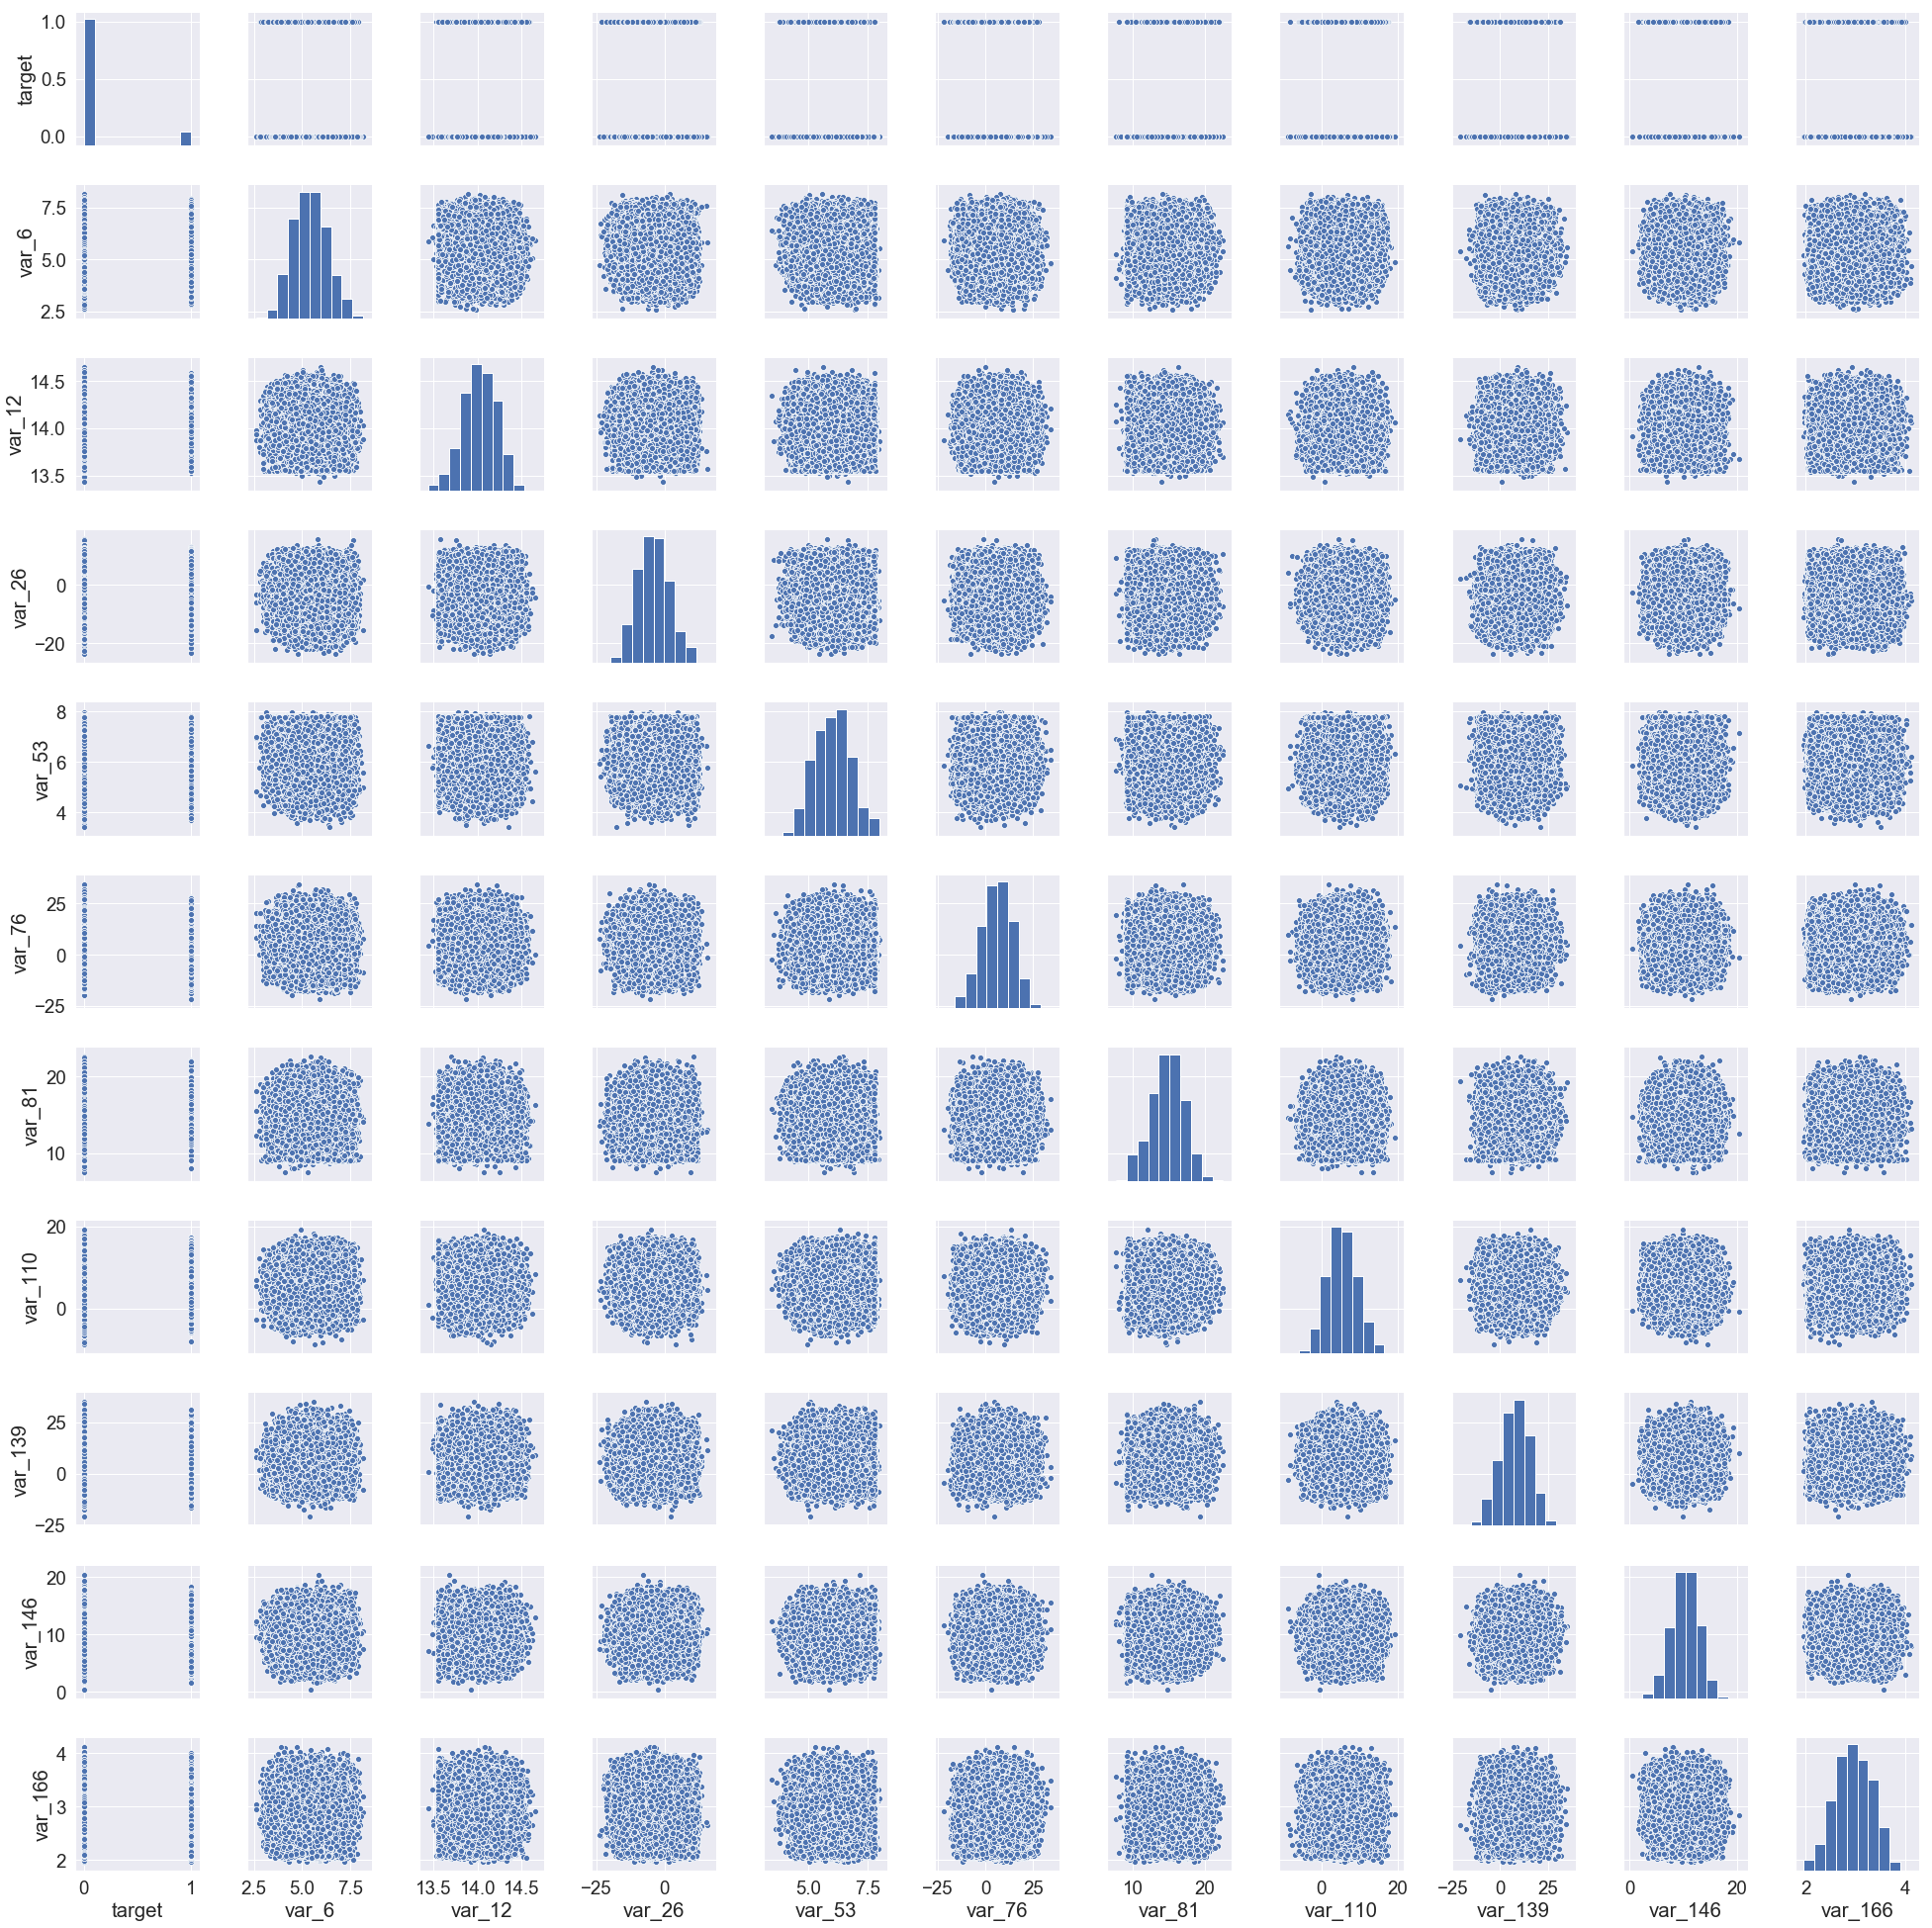

In [13]:
df_pp = df[['target', 'var_6', 'var_12', 'var_26', 'var_53', 'var_76', 'var_81', 'var_110', 'var_139', 'var_146', 'var_166']].copy()

sns.set(font_scale=1.7)
sns.pairplot(df_pp)
plt.show()

Nothing too exciting here; looks like a lot of noise.  We do see that all of these features are very close to normally distributed.  We can also see the previously observed ratio of 1 buy transaction for every 10 transations.

In [14]:
# heatmap
sns.set(font_scale=1.5)
plt.figure(figsize=(15, 7))
corr = df_pp.corr()
corr.style.background_gradient(cmap='coolwarm')

,target,var_6,var_12,var_26,var_53,var_76,var_81,var_110,var_139,var_146,var_166
target,1,0.0702291,-0.0718942,0.0558066,0.0557287,-0.0651526,-0.0841459,0.0652922,-0.0728619,-0.0608347,-0.0587774
var_6,0.0702291,1,-0.00247935,0.00225149,0.00227206,-0.000977535,-0.00123521,-0.00479078,-0.00901396,0.00077159,-0.000965887
var_12,-0.0718942,-0.00247935,1,-0.00161065,-0.00350123,0.0016068,0.00482733,-0.0100816,0.00574199,0.00590632,0.0050556
var_26,0.0558066,0.00225149,-0.00161065,1,-0.0007413,-0.00226262,-0.00631077,0.0010309,-0.00810202,-0.00576406,-0.0109743
var_53,0.0557287,0.00227206,-0.00350123,-0.0007413,1,-0.00481968,-0.00520167,0.000900112,-0.00196003,0.00141975,0.000560983
var_76,-0.0651526,-0.000977535,0.0016068,-0.00226262,-0.00481968,1,0.00180177,-0.00465923,0.00312535,-0.00136017,0.00634887
var_81,-0.0841459,-0.00123521,0.00482733,-0.00631077,-0.00520167,0.00180177,1,-0.0115099,0.00797781,0.00378476,0.00571073
var_110,0.0652922,-0.00479078,-0.0100816,0.0010309,0.000900112,-0.00465923,-0.0115099,1,-0.00409203,0.00135962,-0.00258573
var_139,-0.0728619,-0.00901396,0.00574199,-0.00810202,-0.00196003,0.00312535,0.00797781,-0.00409203,1,0.00453186,0.00100999
var_146,-0.0608347,0.00077159,0.00590632,-0.00576406,0.00141975,-0.00136017,0.00378476,0.00135962,0.00453186,1,0.0047259


<Figure size 1080x504 with 0 Axes>

In [15]:
df.corr().unstack().sort_values().drop_duplicates()

var_81   target    -0.084146
target   var_139   -0.072862
var_12   target    -0.071894
target   var_76    -0.065153
         var_174   -0.063204
var_146  target    -0.060835
target   var_166   -0.058777
         var_148   -0.057561
         var_21    -0.057013
         var_80    -0.056954
         var_165   -0.055337
var_34   target    -0.054265
var_13   target    -0.054053
target   var_198   -0.053843
var_109  target    -0.051392
var_92   target    -0.048374
var_115  target    -0.048126
target   var_44    -0.047259
var_108  target    -0.047088
target   var_122   -0.045518
var_33   target    -0.044389
target   var_154   -0.043708
         var_149   -0.043349
var_87   target    -0.040631
target   var_169   -0.040593
         var_9     -0.040477
         var_172   -0.039692
         var_123   -0.039412
var_86   target    -0.039412
target   var_192   -0.039360
                      ...   
var_180  target     0.035206
var_35   target     0.035772
var_164  target     0.036759
target   var_1

The above heatmap and correlation values show that there is very little correlation between the target variable and the top 10 best predictive features.  It looks like, at this point, we will need to incorporate many features (maybe most of the 200) to improve the predictive value of each model.

## Build the models and evaluate
The first step to building a good model is to separate the data into training and test data.  We'll train the model on the training data and test it with the test data.  This next line of code breaks the dataframe into 2 dataframes: 1 for training and 1 for test.

In [16]:
# Create training and test sets.
offset = int(df.shape[0] * 0.8)

df_train = df[:offset]
df_test = df[offset:]

Confirm the new shapes of the 2 new dataframes.

In [17]:
df_train.shape

(48000, 201)

In [18]:
df_test.shape

(12000, 201)

Again, confirm the existence of about 10% 'buy' rows for the training data. (8034 is about 10% of 80,000 from above)

In [19]:
df_train['target'].sum()

4785

Next, we need to balance the data to account for the current 9 to 1 ratio of 'not buy' to 'buy'.

In [20]:
buy_num = df_train['target'].sum()
print(buy_num)
diff = df_train.shape[0] - buy_num

df_train.drop(df_train.query('target < 1').sample(frac=(1 - (buy_num/diff))).index, inplace=True)
print(df_train.shape)

4785
(9570, 201)


c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Confirm the new shape of the training data.  The new training dataframe has an equal number of 'buy' and 'not buy' rows.

In [21]:
df_train.shape

(9570, 201)

We will use basic Logistic Regression as the first model to calculate the ROC accuracy.

In [22]:
# 1.  Logistic Regression

from datetime import datetime
start_time = datetime.now()

# Instantiate our model.
regr = linear_model.LogisticRegression(solver='sag')

# set features and dependent variable for training data
y_train = df_train['target'].values

# drop the 'target' column to obtain the feature inputs
df_train.drop(['target'], axis=1, inplace=True)

# normalize the training data
x_train = sklearn.preprocessing.normalize(df_train)

# now for test...
y_test = df_test['target'].values

# drop the 'target' column to obtain the feature inputs
df_test.drop(['target'], axis=1, inplace=True)

# normalize the test data
x_test = sklearn.preprocessing.normalize(df_test)

# fit model to training data
regr.fit(x_train, y_train)

print('\nR-squared (training):')
print(regr.score(x_train, y_train))
print('\nR-squared (test):')
print(regr.score(x_test, y_test))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)



R-squared (training):
0.7458725182863114

R-squared (test):
0.74425

Duration: 0:00:01.011058


In [23]:
from sklearn import metrics
y_test_pred = regr.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.7433874003367948

In [24]:
# 2.  Extra Trees Classifier

from datetime import datetime
start_time = datetime.now()

from sklearn.ensemble import ExtraTreesClassifier

# Instantiate our model.
etc = ExtraTreesClassifier(n_estimators=500)

# fit model to data
etc.fit(x_train, y_train)

print('\nR-squared (training):')
print(etc.score(x_train, y_train))
print('\nR-squared (test):')
print(etc.score(x_test, y_test))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


R-squared (training):
1.0

R-squared (test):
0.78675

Duration: 0:00:26.414510


In [25]:
from sklearn import metrics
y_test_pred = etc.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.7703017724025243

In [26]:
# 3.  Random Forest Classifier

from datetime import datetime
start_time = datetime.now()

from sklearn.ensemble import RandomForestClassifier

# Instantiate our model.
rfc = RandomForestClassifier(n_estimators=500)

# fit model to data
rfc.fit(x_train, y_train)

#------------------------------------------------------------------------------
sfm = SelectFromModel(rfc, threshold=0.001, max_features=10)
sfm.fit(x_train, y_train)
sfm.get_support()
selected_feat = df_train.columns[(sfm.get_support())]
len(selected_feat)
print(selected_feat)
#selected_feat(sfm.estimator_, feature_importances_).ravel().hist()
#------------------------------------------------------------------------------

feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = df_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

print('\nR-squared (training):')
print(rfc.score(x_train, y_train))
print('\nR-squared (test):')
print(rfc.score(x_test, y_test))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

Index(['var_6', 'var_21', 'var_22', 'var_76', 'var_80', 'var_81', 'var_110',
       'var_139', 'var_146', 'var_174'],
      dtype='object')

R-squared (training):
1.0

R-squared (test):
0.7456666666666667

Duration: 0:03:14.114102


In [27]:
print((feature_importances).head(10))

         importance
var_139    0.014845
var_81     0.014593
var_6      0.010786
var_22     0.010194
var_76     0.009902
var_146    0.009852
var_21     0.008928
var_174    0.008493
var_110    0.008420
var_80     0.008360


In [28]:
from sklearn import metrics
y_test_pred = rfc.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.7646253241566359

In [29]:
# 4.  Gradient Boosting Classifier

from datetime import datetime
start_time = datetime.now()

from sklearn.ensemble import GradientBoostingClassifier

# Instantiate our model.
gbc = GradientBoostingClassifier(n_estimators=500)

# fit model to data
gbc.fit(x_train, y_train)

print('\nR-squared (training):')
print(gbc.score(x_train, y_train))
print('\nR-squared (test):')
print(gbc.score(x_test, y_test))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


R-squared (training):
0.9632183908045977

R-squared (test):
0.7950833333333334

Duration: 0:01:57.942746


In [30]:
from sklearn import metrics
y_test_pred = gbc.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.7828383882147744

With just the 10 best features (from Random Forest 'feature_selections_').

In [31]:
# 5.  GBC with just the 10 best features (n_estimators=500)

from datetime import datetime
start_time = datetime.now()

from sklearn.ensemble import GradientBoostingClassifier

# Instantiate our model.
gbc_10 = GradientBoostingClassifier(n_estimators=500)

x_train_10 = sklearn.preprocessing.normalize(df_train[['var_6', 'var_12', 'var_22', 'var_26', 'var_53', 'var_76', 'var_81', 
                    'var_110', 'var_139', 'var_146']])

x_test_10 = sklearn.preprocessing.normalize(df_test[['var_6', 'var_12', 'var_22', 'var_26', 'var_53', 'var_76', 'var_81', 
                                              'var_110', 'var_139', 'var_146']])

# fit model to data
gbc_10.fit(x_train_10, y_train)

print('\nR-squared (training):')
print(gbc_10.score(x_train_10, y_train))
print('\nR-squared (test):')
print(gbc_10.score(x_test_10, y_test))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


R-squared (training):
0.774712643678161

R-squared (test):
0.6605833333333333

Duration: 0:00:07.253415


In [32]:
from sklearn import metrics
y_test_pred = gbc_10.predict(x_test_10)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.6268040692365153

In [33]:
# 6.  Support Vector Classifier

from datetime import datetime
start_time = datetime.now()

from sklearn.svm import SVC

# Instantiate our model.
sv_c = SVC(gamma='auto')

# fit model to data
sv_c.fit(x_train, y_train)

print('\nR-squared (training):')
print(sv_c.score(x_train, y_train))
print('\nR-squared (test):')
print(sv_c.score(x_test, y_test))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


R-squared (training):
0.6688610240334378

R-squared (test):
0.6818333333333333

Duration: 0:01:28.635070


In [34]:
from sklearn import metrics
y_test_pred = sv_c.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.6648352111560766

In [35]:
# 7.  Voting Classifier with LR, RFC, and NB

from datetime import datetime
start_time = datetime.now()

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

clf1 = LogisticRegression(solver='sag')
clf2 = RandomForestClassifier(n_estimators=500)
clf3 = GaussianNB()
# clf4 = GradientBoostingClassifier(n_estimators=200)
# clf5 = SVC

eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

eclf1 = eclf1.fit(x_train, y_train)

print('\nR-squared (training):')
print(sv_c.score(x_train, y_train))
print('\nR-squared (test):')
print(sv_c.score(x_test, y_test))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


R-squared (training):
0.6688610240334378

R-squared (test):
0.6818333333333333

Duration: 0:02:34.066812


In [36]:
from sklearn import metrics
y_test_pred = eclf1.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.7841278639669697

In [37]:
# 8.  Naive Bayes Bernoulli Classifier

from datetime import datetime
start_time = datetime.now()

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(x_train, y_train)

print('\nR-squared (training):')
print(bnb.score(x_train, y_train))
print('\nR-squared (test):')
print(bnb.score(x_test, y_test))



R-squared (training):
0.6598746081504702

R-squared (test):
0.6598333333333334


In [38]:
from sklearn import metrics
y_test_pred = bnb.predict(x_test)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.6482694634739112

In [39]:
# 9.  Naive Bayes Bernoulli Classifier with just 10 best features

from datetime import datetime
start_time = datetime.now()

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb_10 = BernoulliNB()

# Fit our model to the data.
bnb_10.fit(x_train_10, y_train)

print('\nR-squared (training):')
print(bnb_10.score(x_train_10, y_train))
print('\nR-squared (test):')
print(bnb_10.score(x_test_10, y_test))


R-squared (training):
0.5765935214211076

R-squared (test):
0.5348333333333334


In [40]:
from sklearn import metrics
y_test_pred = bnb_10.predict(x_test_10)
sklearn.metrics.roc_auc_score(y_test, y_test_pred)

0.5656909274680992

## Conclusion and discussion
First of all the number of rows dropped (140,000) definitely has an impact on the performance of each model.  Another significant influence to model accuracy (area under the ROC curve) was the number of 'n_estimators' used in the random forest, extra tree classifier and gradient boosting classifier.  Using 100 n_estimators achieved better results than 10 and 500 got better results than 100; however, the higher this number, the higher the solve times.  There is definitely a trade off.  

Using just the 10 best features was a quick way to test to see if eliminating some noise in the data could yield better results.  These test results did not produce better results; they were worse.  It seems that eliminating some of the weaker correlated features could produce better accuracy measures, but which ones to eliminate (out of the 200) is a tricky question.  More study is needed.  

The results for all 9 models (in decreasing AUC ROC performance) are as follows:
- Voting Classifier with LR, RFC, and NB:  0.784
- Gradient Boosting Classifier:  0.783
- Extra Tree Classifier:  0.770
- Random Forest Classifier:  0.765
- Logistic Regression:  0.743
- Support Vector Classifier:  0.665
- Bernoulli Naive Bayes:  0.648
- Graient Boosting with 10 features:  0.627
- Bernoulli NB with 10 features:  0.566  

Another major factor in increasing accuracy results was adjusting for class imbalance.  Models that did not make the adjustment were quickly discarded and performed significantly worse - around 10 to 15% worse - than models shown in this study which made the adjustment.  

Overall, the best models were ensemble models.  In fact, they comprised the top 4 performing models.  Many more modeling techniques exist and can be studied in the future to compare against the resluts obtained here.  